PART 1: CLASSIFICATION TASK (Diabetes Prediction)


Step 1: EDA and Data Understanding

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Load Dataset
df_diabetes = pd.read_csv('diabetes_prediction_dataset.csv')

In [ ]:
#Basic info of Dataset
print(df_diabetes.shape)
print(df_diabetes.info())
print(df_diabetes.describe())
print(df_diabetes.head())

(100000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.1945

In [ ]:
# Check for missing values
print(df_diabetes.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


diabetes_label
No Diabetes    91500
Diabetes        8500
Name: count, dtype: int64


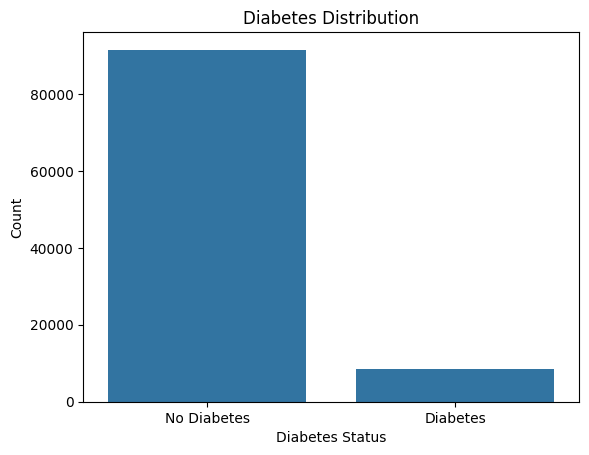

In [ ]:
# Check target distribution
df_diabetes['diabetes_label'] = df_diabetes['diabetes'].map({
    0: 'No Diabetes',
    1: 'Diabetes'
})

print(df_diabetes['diabetes_label'].value_counts())

sns.countplot(data=df_diabetes, x='diabetes_label')
plt.title('Diabetes Distribution')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.show()


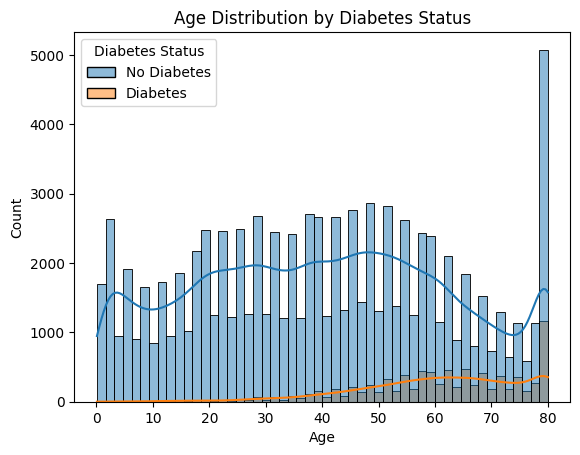

In [ ]:
# 1. Age distribution by diabetes status
ax = sns.histplot(
    data=df_diabetes,
    x='age',
    hue='diabetes_label',
    kde=True
)

ax.legend_.set_title('Diabetes Status')

plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


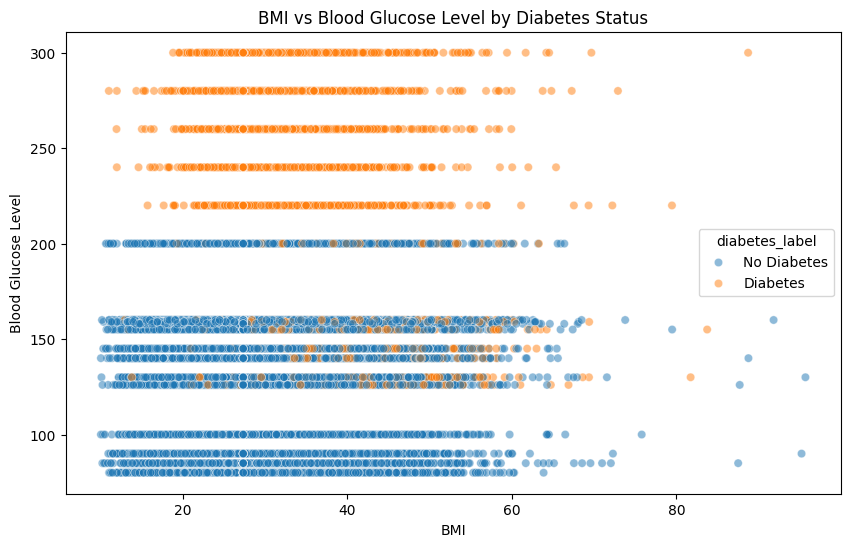

In [ ]:
# 2. BMI vs Blood Glucose
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_diabetes,
    x='bmi',
    y='blood_glucose_level',
    hue='diabetes_label',
    alpha=0.5
)
plt.title('BMI vs Blood Glucose Level by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Blood Glucose Level')
plt.show()


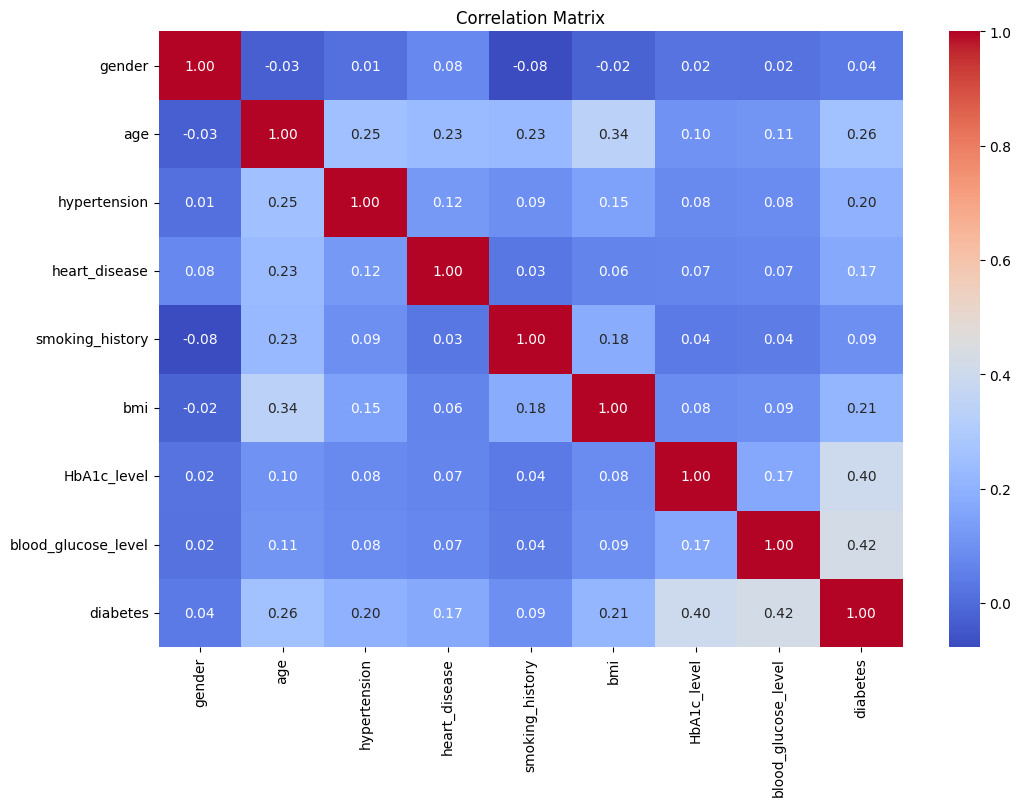

In [ ]:
# 3. Correlation heatmap
plt.figure(figsize=(12, 8))

df_temp = df_diabetes.copy()

# Encode categorical variables
le = LabelEncoder()
df_temp['gender'] = le.fit_transform(df_temp['gender'])
df_temp['smoking_history'] = le.fit_transform(df_temp['smoking_history'])

#only numeric columns
corr = df_temp.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


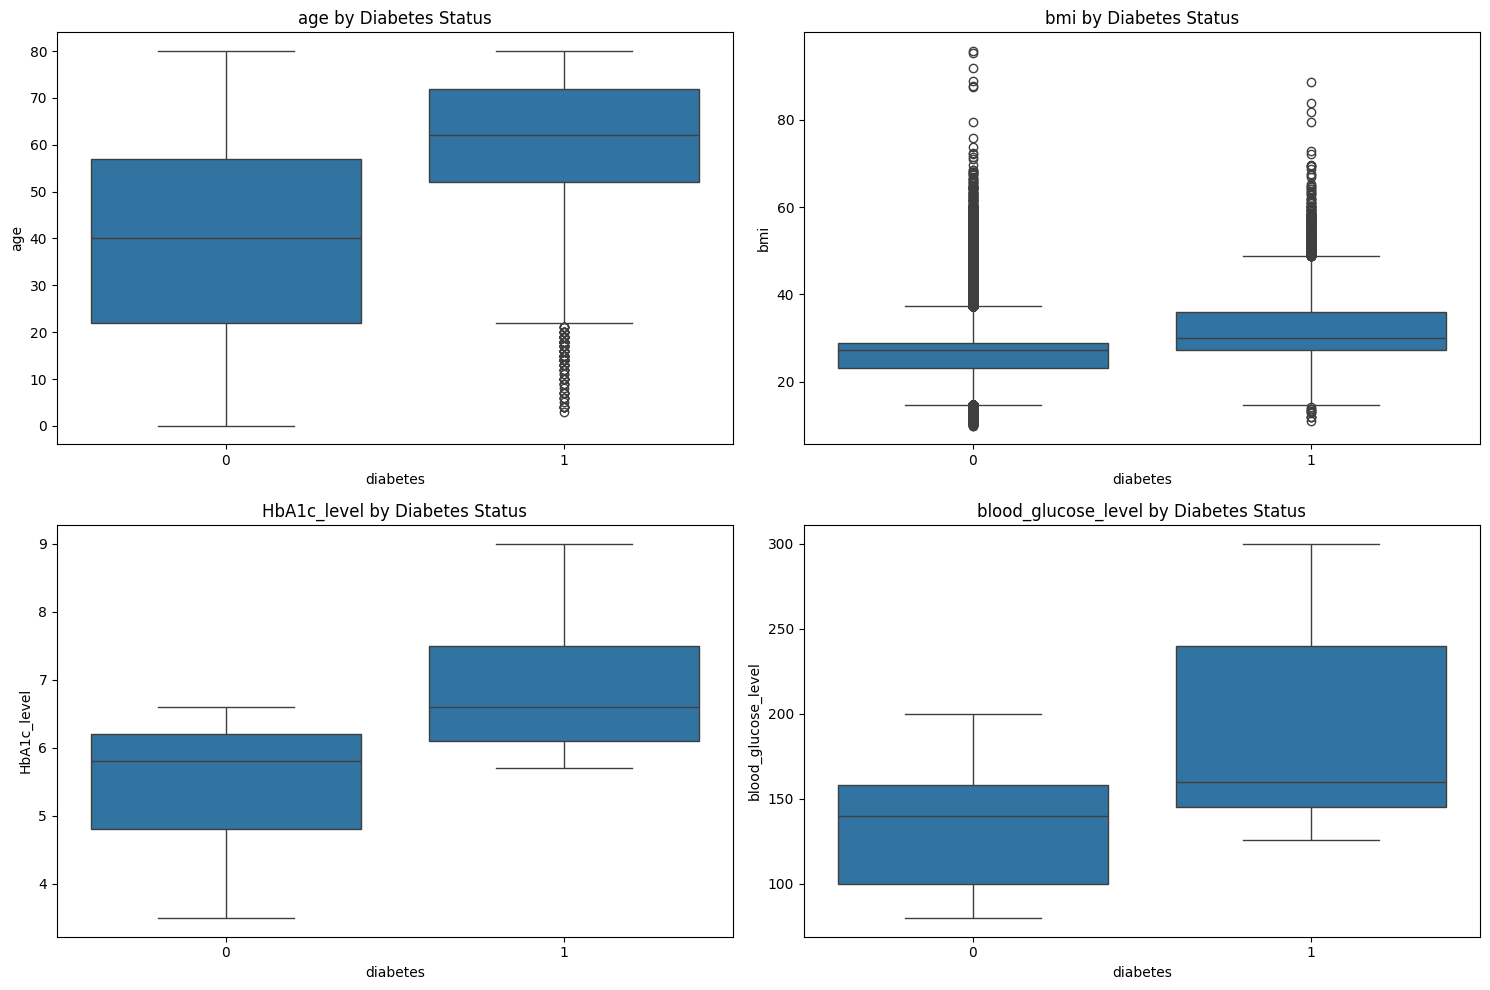

In [ ]:
# 4. Box plots for numerical features
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for idx, col in enumerate(numerical_cols):
    ax = axes[idx//2, idx%2]
    sns.boxplot(data=df_diabetes, x='diabetes', y=col, ax=ax)
    ax.set_title(f'{col} by Diabetes Status')
plt.tight_layout()
plt.show()

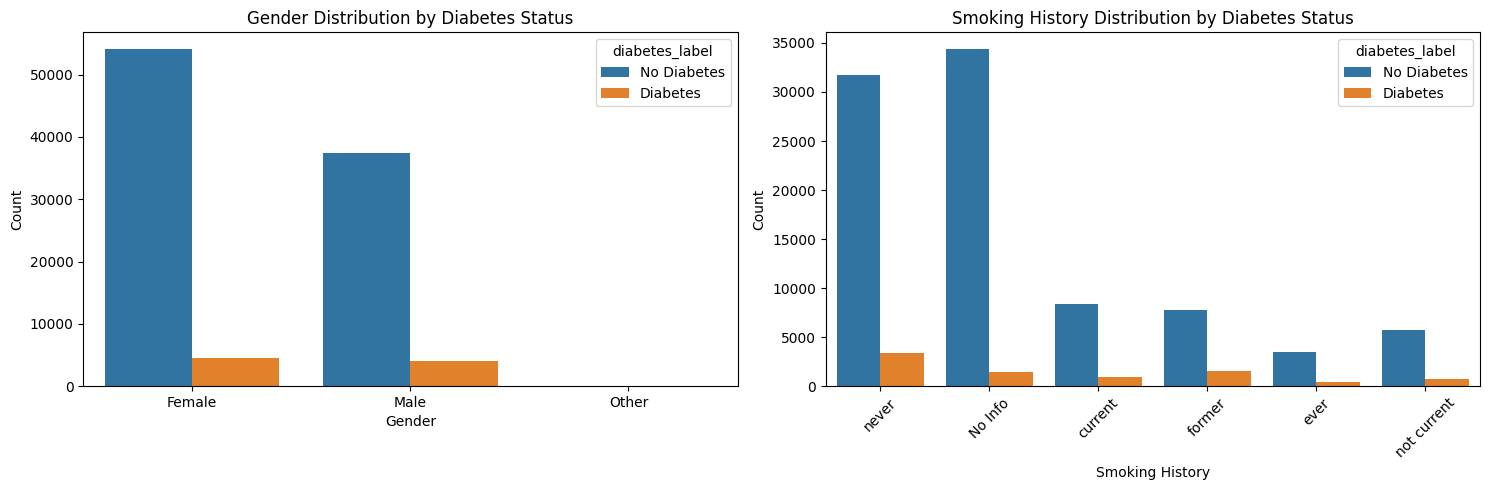

In [ ]:
# 5. Gender and smoking history analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(
    data=df_diabetes,
    x='gender',
    hue='diabetes_label',   #
    ax=axes[0]
)
axes[0].set_title('Gender Distribution by Diabetes Status')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

sns.countplot(
    data=df_diabetes,
    x='smoking_history',
    hue='diabetes_label',
    ax=axes[1]
)
axes[1].set_title('Smoking History Distribution by Diabetes Status')
axes[1].set_xlabel('Smoking History')
axes[1].set_ylabel('Count')

plt.setp(axes[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()


Data Preprocessing

In [ ]:
# Handle categorical variables
df_diabetes_processed = df_diabetes.copy()

# Encode gender
df_diabetes_processed['gender'] = le.fit_transform(df_diabetes_processed['gender'])

# Encode smoking_history
df_diabetes_processed['smoking_history'] = le.fit_transform(df_diabetes_processed['smoking_history'])

In [ ]:
# Check for outliers using IQR method
def detect_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
        print(f"{col}: {len(outliers)} outliers detected")

detect_outliers(df_diabetes_processed, numerical_cols)

age: 0 outliers detected
bmi: 7086 outliers detected
HbA1c_level: 1315 outliers detected
blood_glucose_level: 2038 outliers detected


In [ ]:
# Separate features and target
X = df_diabetes_processed.drop('diabetes', axis=1)
y = df_diabetes_processed['diabetes']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separate numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Create a transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),        # scale numeric
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # encode categorical
    ]
)

# Fit and transform train, transform test
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(X_train_scaled.shape)


(80000, 9)


Step 2: Build Neural Network

In [ ]:
# Import necessary libraries
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Build Neural Network
model_nn = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer with 64 neurons
    layers.Dropout(0.3),  # Dropout layer to prevent overfitting
    layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    layers.Dropout(0.2),  # Dropout layer
    layers.Dense(16, activation='relu'),  # Hidden layer with 16 neurons
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])
#compile model
model_nn.compile(
    optimizer='adam',  # Optimizer
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metric to monitor
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Printng model architecture
model_nn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train model
history = model_nn.fit(
    X_train_scaled, y_train,
    epochs=50,           # Number of training epochs
    batch_size=32,       # Batch size
    validation_split=0.2,  # 20% of training data for validation
    verbose=1
)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9720 - loss: 0.0925 - val_accuracy: 1.0000 - val_loss: 9.1896e-05
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9999 - loss: 3.7881e-04 - val_accuracy: 1.0000 - val_loss: 8.3054e-06
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 1.6274e-04 - val_accuracy: 1.0000 - val_loss: 2.7911e-07
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 1.0000 - loss: 3.8867e-05 - val_accuracy: 1.0000 - val_loss: 5.4166e-07
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 1.0000 - loss: 4.2944e-05 - val_accuracy: 1.0000 - val_loss: 4.8812e-08
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 8.7529e-06 - val_accuracy: 1.0000 - val_loss: 2.7039e-08
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 1.0000 - loss: 1.5324e-06 - val_accuracy: 1.0000 - val_loss: 2.4415e-09
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━

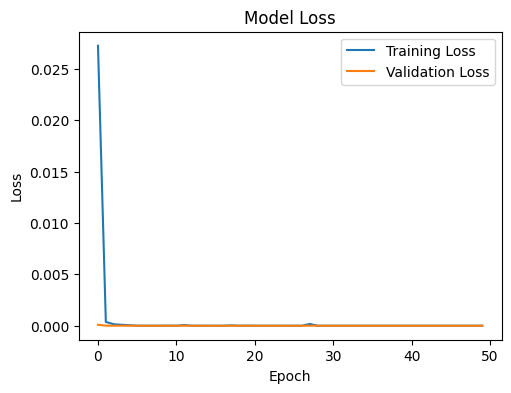

In [ ]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

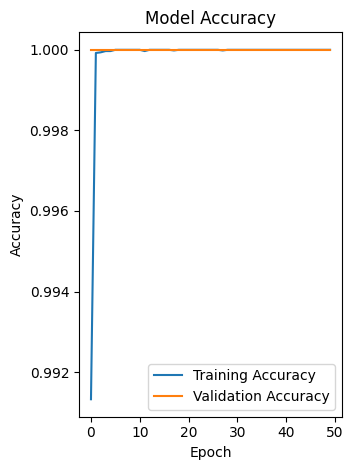

In [ ]:
# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Evulation on test sets
y_pred_nn = (model_nn.predict(X_test_scaled) > 0.5).astype(int).flatten()  # Predict and convert probabilities to 0/1

# Print performance metrics
print("Neural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn):.4f}")     # Accuracy
print(f"Precision: {precision_score(y_test, y_pred_nn):.4f}")   # Precision
print(f"Recall: {recall_score(y_test, y_pred_nn):.4f}")         # Recall
print(f"F1-Score: {f1_score(y_test, y_pred_nn):.4f}")           # F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step
Neural Network Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18300
           1       1.00      1.00      1.00      1700

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



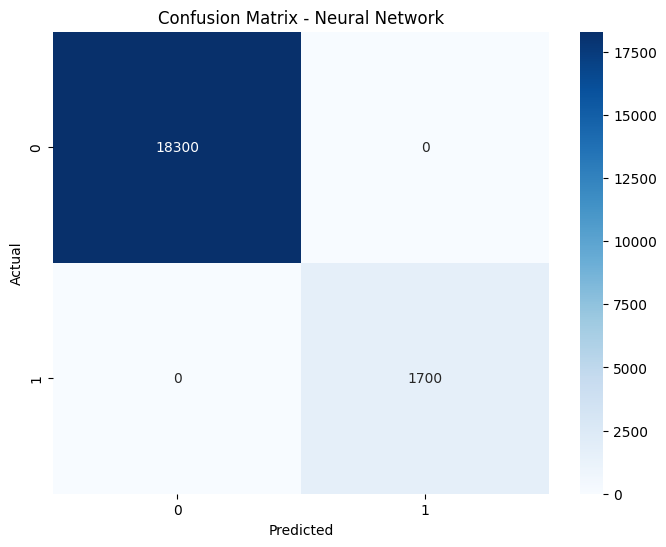

In [ ]:
#Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Step 3: Build Two Classical ML Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Model 1: Logistic Regression
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")


Logistic Regression Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [ ]:
# Model 2: Random Forest
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")



Random Forest Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [ ]:
# Initial comparison
print("Initial Model Comparison")
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_rf)],
    'F1-Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf)]
})
print(models_comparison)


Initial Model Comparison
                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression       1.0        1.0     1.0       1.0
1        Random Forest       1.0        1.0     1.0       1.0


Step 4: Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_lr.fit(X_train_scaled, y_train)

print("Best parameters for Logistic Regression:", grid_lr.best_params_)
print("Best CV F1-Score:", grid_lr.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Logistic Regression: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
Best CV F1-Score: 1.0


In [ ]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train_scaled, y_train)

print("\nBest parameters for Random Forest:", grid_rf.best_params_)
print("Best CV F1-Score:", grid_rf.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV F1-Score: 1.0


Step 5: Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# RFE for Logistic Regression
lr_estimator = LogisticRegression(max_iter=1000, random_state=42)

rfe_lr = RFE(
    estimator=lr_estimator,
    n_features_to_select=5
)

rfe_lr.fit(X_train_scaled, y_train)

X_train_selected_lr = rfe_lr.transform(X_train_scaled)
X_test_selected_lr = rfe_lr.transform(X_test_scaled)

selected_features_lr = X.columns[rfe_lr.support_]

print("\nSelected Features (Logistic Regression):")
print(list(selected_features_lr))


Selected Features (Logistic Regression):
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes_label']


In [ ]:
# RFE for Random Forest
rf_estimator = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rfe_rf = RFE(
    estimator=rf_estimator,
    n_features_to_select=5
)

rfe_rf.fit(X_train_scaled, y_train)

X_train_selected_rf = rfe_rf.transform(X_train_scaled)
X_test_selected_rf = rfe_rf.transform(X_test_scaled)

selected_features_rf = X.columns[rfe_rf.support_]

print("\nSelected Features (Random Forest):")
print("─" * 45)
for i, feature in enumerate(selected_features_rf, 1):
    print(f"  {i:2d}. {feature}")
print("─" * 45)


Selected Features (Random Forest):
─────────────────────────────────────────────
   1. age
   2. hypertension
   3. HbA1c_level
   4. blood_glucose_level
   5. diabetes_label
─────────────────────────────────────────────


In [ ]:
# Feature Comparison Table
task5_comparison = pd.DataFrame({
    "Logistic Regression (RFE)": selected_features_lr,
    "Random Forest (RFE)": selected_features_rf
})

print("\nComparison of Selected Features:")
print(task5_comparison)


Comparison of Selected Features:
  Logistic Regression (RFE)  Random Forest (RFE)
0                       age                  age
1                       bmi         hypertension
2               HbA1c_level          HbA1c_level
3       blood_glucose_level  blood_glucose_level
4            diabetes_label       diabetes_label


Step 6: Final Models and Comparison

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Final Logistic Regression Model (Tuned + RFE)
final_lr = LogisticRegression(
    C=grid_lr.best_params_['C'],
    penalty=grid_lr.best_params_['penalty'],
    solver=grid_lr.best_params_['solver'],
    max_iter=1000,
    random_state=42
)

cv_lr = cross_val_score(
    final_lr, X_train_selected_lr, y_train, cv=5, scoring='f1'
).mean()

final_lr.fit(X_train_selected_lr, y_train)
y_pred_lr = final_lr.predict(X_test_selected_lr)

In [ ]:
#Final Random Forest Model (Tuned + RFE)
final_rf = RandomForestClassifier(
    n_estimators=grid_rf.best_params_['n_estimators'],
    max_depth=grid_rf.best_params_['max_depth'],
    min_samples_split=grid_rf.best_params_['min_samples_split'],
    min_samples_leaf=grid_rf.best_params_['min_samples_leaf'],
    random_state=42
)

cv_rf = cross_val_score(
    final_rf, X_train_selected_rf, y_train, cv=5, scoring='f1'
).mean()

final_rf.fit(X_train_selected_rf, y_train)
y_pred_rf = final_rf.predict(X_test_selected_rf)

In [ ]:
table_4 = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Features": f"Selected ({X_train_selected_lr.shape[1]})",
        "CV Score": cv_lr,
        "Accuracy": accuracy_score(y_test, y_pred_lr),
        "Precision": precision_score(y_test, y_pred_lr),
        "Recall": recall_score(y_test, y_pred_lr),
        "F1-Score": f1_score(y_test, y_pred_lr)
    },
    {
        "Model": "Random Forest",
        "Features": f"Selected ({X_train_selected_rf.shape[1]})",
        "CV Score": cv_rf,
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1-Score": f1_score(y_test, y_pred_rf)
    }
])

print("\nTable 4: Comparison of Final Classification Models")
print(table_4)



Table 4: Comparison of Final Classification Models
                 Model      Features  CV Score  Accuracy  Precision  Recall  \
0  Logistic Regression  Selected (5)       1.0       1.0        1.0     1.0   
1        Random Forest  Selected (5)       1.0       1.0        1.0     1.0   

   F1-Score  
0       1.0  
1       1.0  


PART 2: REGRESSION TASK (Electricity Cost Prediction)

In [ ]:
# Load and explore regression dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load data
df_electricity = pd.read_csv('electricity_cost_dataset.csv')

In [ ]:
# Basic info
print("Dataset Shape:", df_electricity.shape)

print("\nDataset Info:")
print(df_electricity.info())

print("\nFirst few rows:")
print(df_electricity.head())

print("\nSummary Statistics:")
print(df_electricity.describe())


Dataset Shape: (10000, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   site area             10000 non-null  int64  
 1   structure type        10000 non-null  object 
 2   water consumption     10000 non-null  float64
 3   recycling rate        10000 non-null  int64  
 4   utilisation rate      10000 non-null  int64  
 5   air qality index      10000 non-null  int64  
 6   issue reolution time  10000 non-null  int64  
 7   resident count        10000 non-null  int64  
 8   electricity cost      10000 non-null  float64
dtypes: float64(2), int64(6), object(1)
memory usage: 703.3+ KB
None

First few rows:
   site area structure type  water consumption  recycling rate  \
0       1360      Mixed-use             2519.0              69   
1       4272      Mixed-use             2324.0              50   
2      

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df_electricity.isnull().sum())


Missing Values:
site area               0
structure type          0
water consumption       0
recycling rate          0
utilisation rate        0
air qality index        0
issue reolution time    0
resident count          0
electricity cost        0
dtype: int64


In [ ]:
# Check data types
print("\nData Types:")
print(df_electricity.dtypes)


Data Types:
site area                 int64
structure type           object
water consumption       float64
recycling rate            int64
utilisation rate          int64
air qality index          int64
issue reolution time      int64
resident count            int64
electricity cost        float64
dtype: object


In [ ]:
# Check unique values for categorical column
print("\nStructure Types:")
print(df_electricity['structure type'].value_counts())


Structure Types:
structure type
Residential    3939
Commercial     3005
Mixed-use      2052
Industrial     1004
Name: count, dtype: int64


Key EDA Visualizations

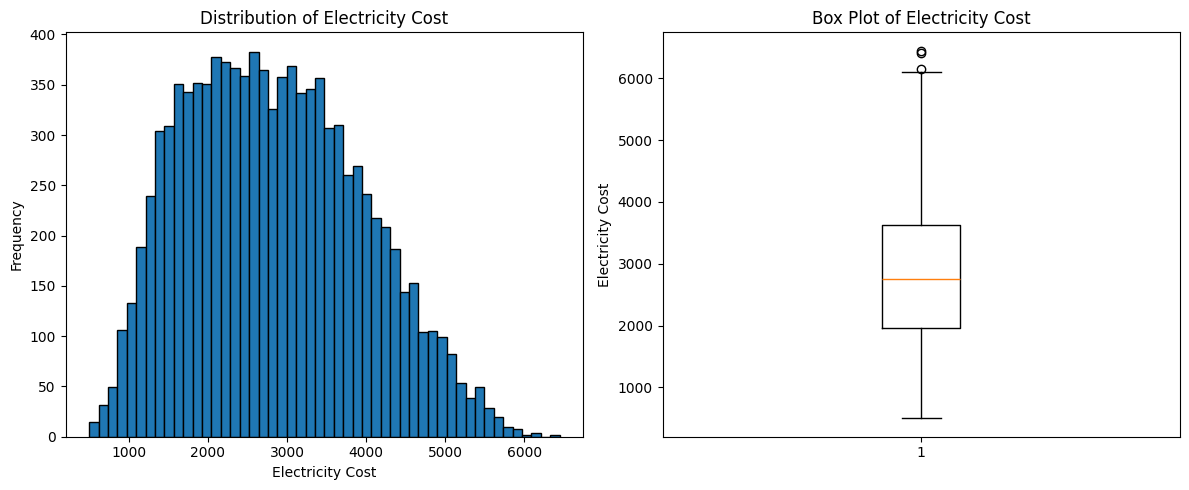

In [ ]:
# 1. Target variable distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_electricity['electricity cost'], bins=50, edgecolor='black')
plt.xlabel('Electricity Cost')
plt.ylabel('Frequency')
plt.title('Distribution of Electricity Cost')

plt.subplot(1, 2, 2)
plt.boxplot(df_electricity['electricity cost'])
plt.ylabel('Electricity Cost')
plt.title('Box Plot of Electricity Cost')
plt.tight_layout()
plt.show()

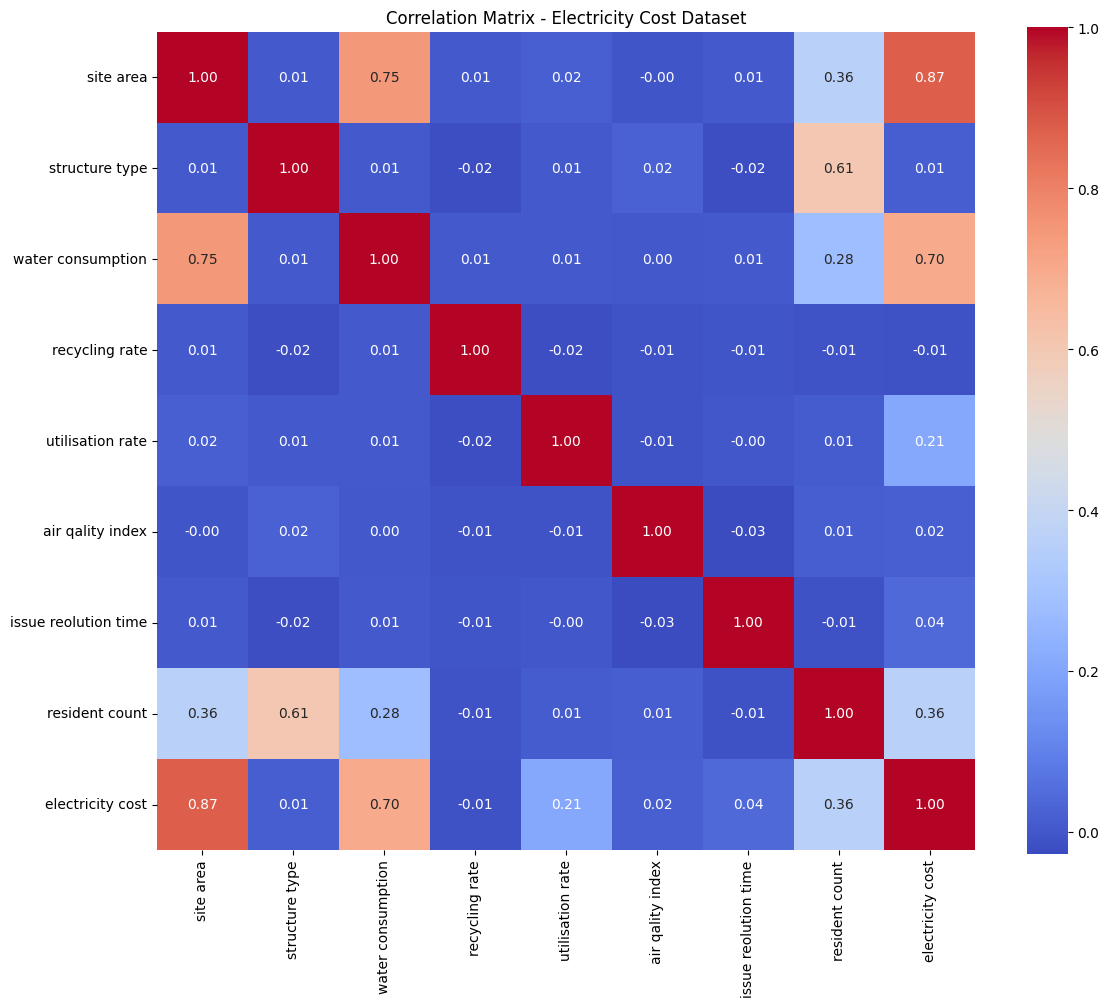


Correlations with Electricity Cost:
electricity cost        1.000000
site area               0.874376
water consumption       0.698775
resident count          0.361609
utilisation rate        0.207215
issue reolution time    0.042325
air qality index        0.017376
structure type          0.014393
recycling rate         -0.012536
Name: electricity cost, dtype: float64


In [ ]:
# 2. Correlation heatmap
plt.figure(figsize=(12, 10))
# Encode categorical variable for correlation
df_temp = df_electricity.copy()
le = LabelEncoder()
df_temp['structure type'] = le.fit_transform(df_temp['structure type'])
correlation_matrix = df_temp.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix - Electricity Cost Dataset')
plt.tight_layout()
plt.show()

# Print correlations with target
print("\nCorrelations with Electricity Cost:")
print(correlation_matrix['electricity cost'].sort_values(ascending=False))

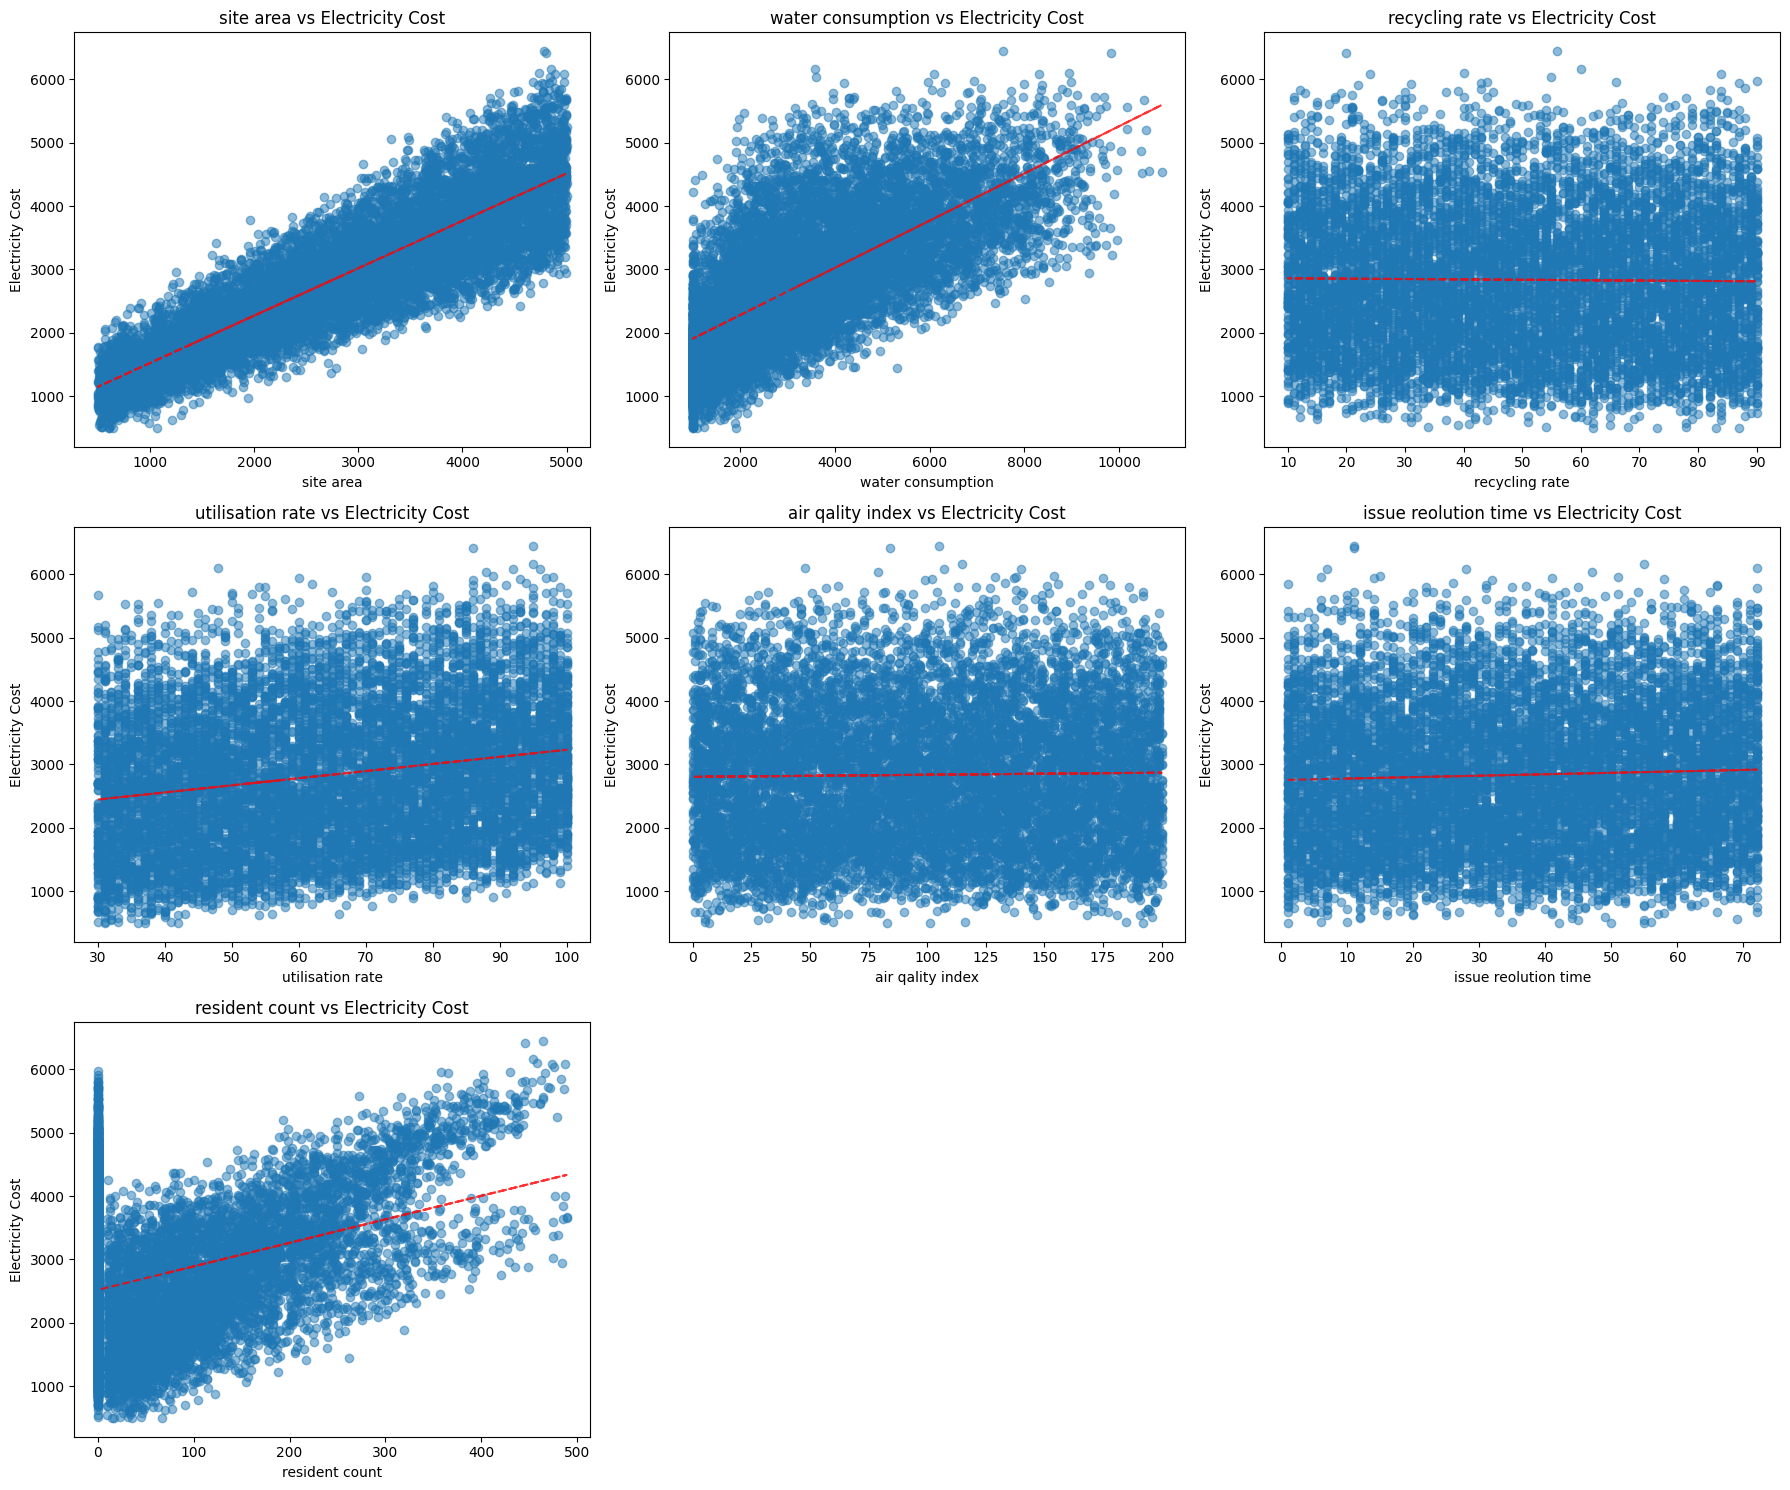

In [ ]:
# 3. Scatter plots - Numerical features vs Electricity Cost
numerical_cols = ['site area', 'water consumption', 'recycling rate',
                  'utilisation rate', 'air qality index', 'issue reolution time',
                  'resident count']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].scatter(df_electricity[col], df_electricity['electricity cost'], alpha=0.5)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Electricity Cost')
    axes[idx].set_title(f'{col} vs Electricity Cost')

    # Add trend line
    z = np.polyfit(df_electricity[col], df_electricity['electricity cost'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df_electricity[col], p(df_electricity[col]), "r--", alpha=0.8)

# Hide extra subplot
axes[7].axis('off')
axes[8].axis('off')
plt.tight_layout()
plt.show()


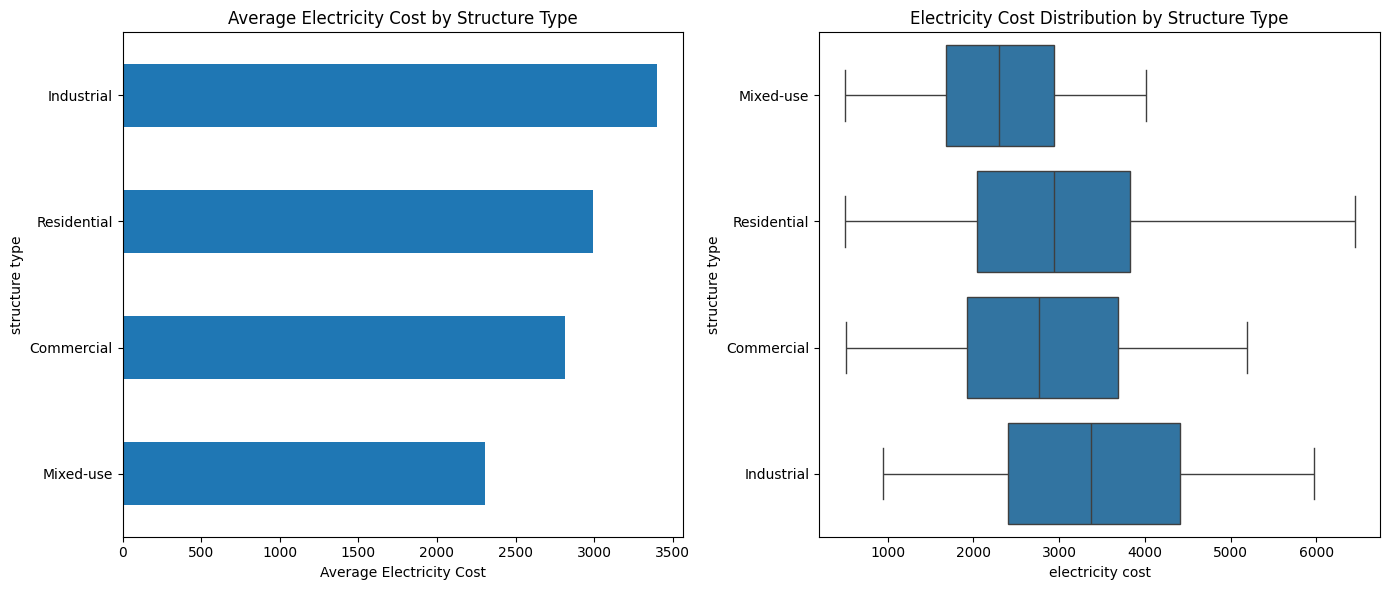

In [ ]:
# 4. Structure Type analysis
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df_electricity.groupby('structure type')['electricity cost'].mean().sort_values().plot(kind='barh')
plt.xlabel('Average Electricity Cost')
plt.title('Average Electricity Cost by Structure Type')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_electricity, y='structure type', x='electricity cost')
plt.title('Electricity Cost Distribution by Structure Type')
plt.tight_layout()
plt.show()


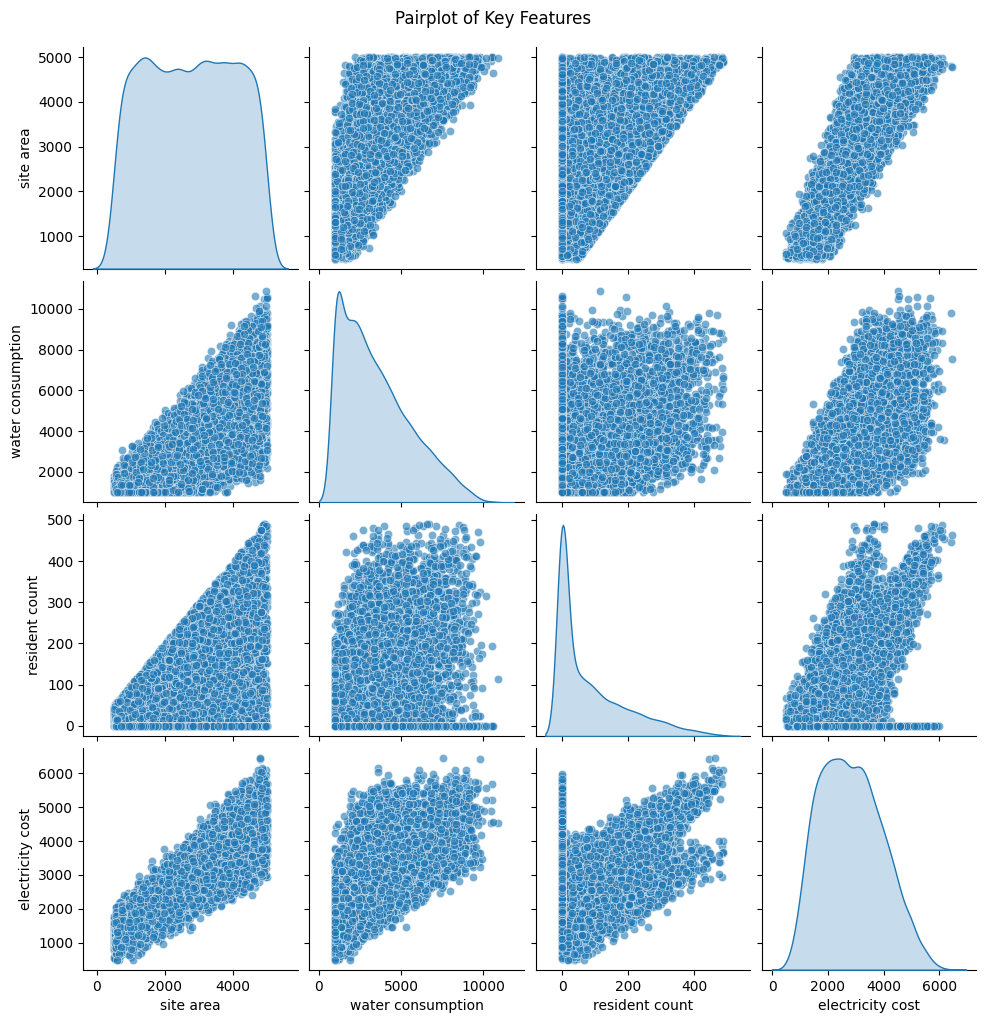

In [ ]:
# 5. Pairplot for key features
key_features = ['site area', 'water consumption', 'resident count', 'electricity cost']
sns.pairplot(df_electricity[key_features], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

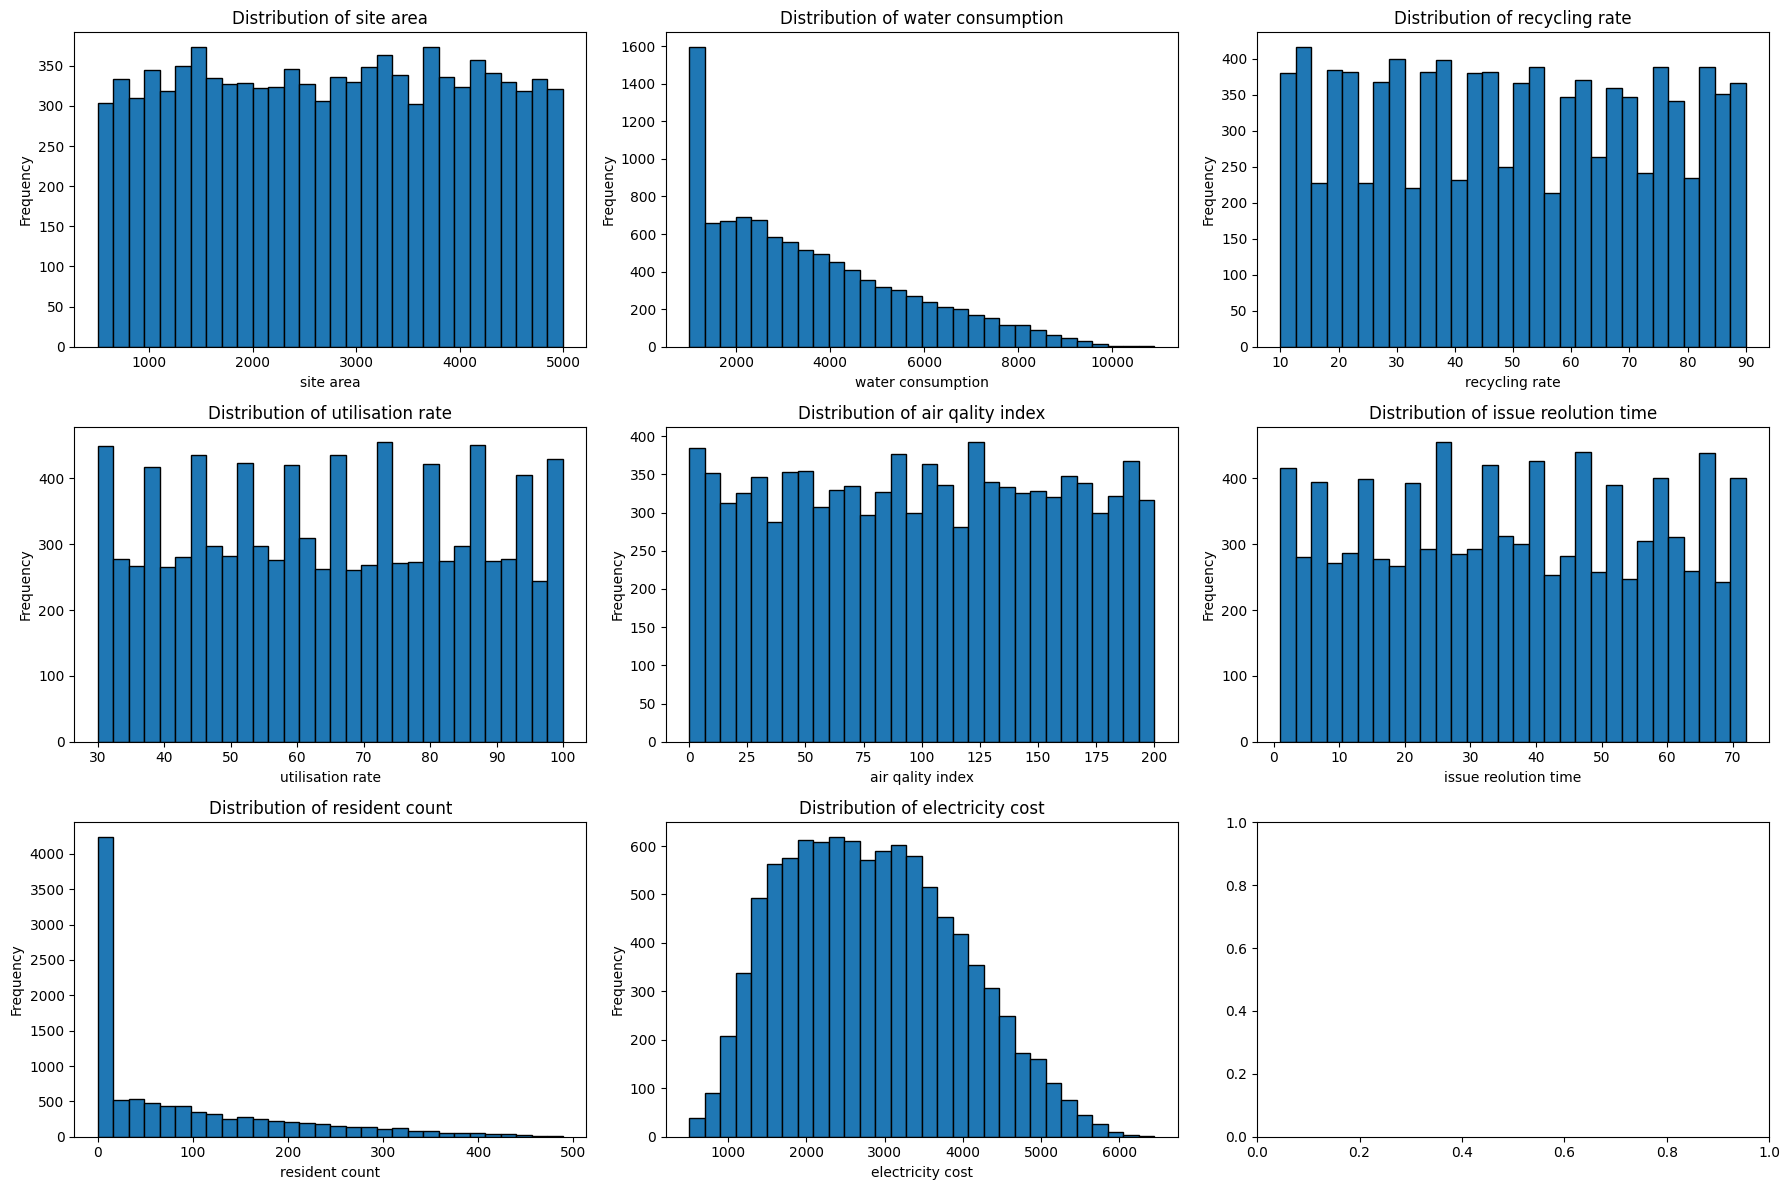

In [ ]:
# 6. Distribution of all numerical features
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols + ['electricity cost']):
    axes[idx].hist(df_electricity[col], bins=30, edgecolor='black')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

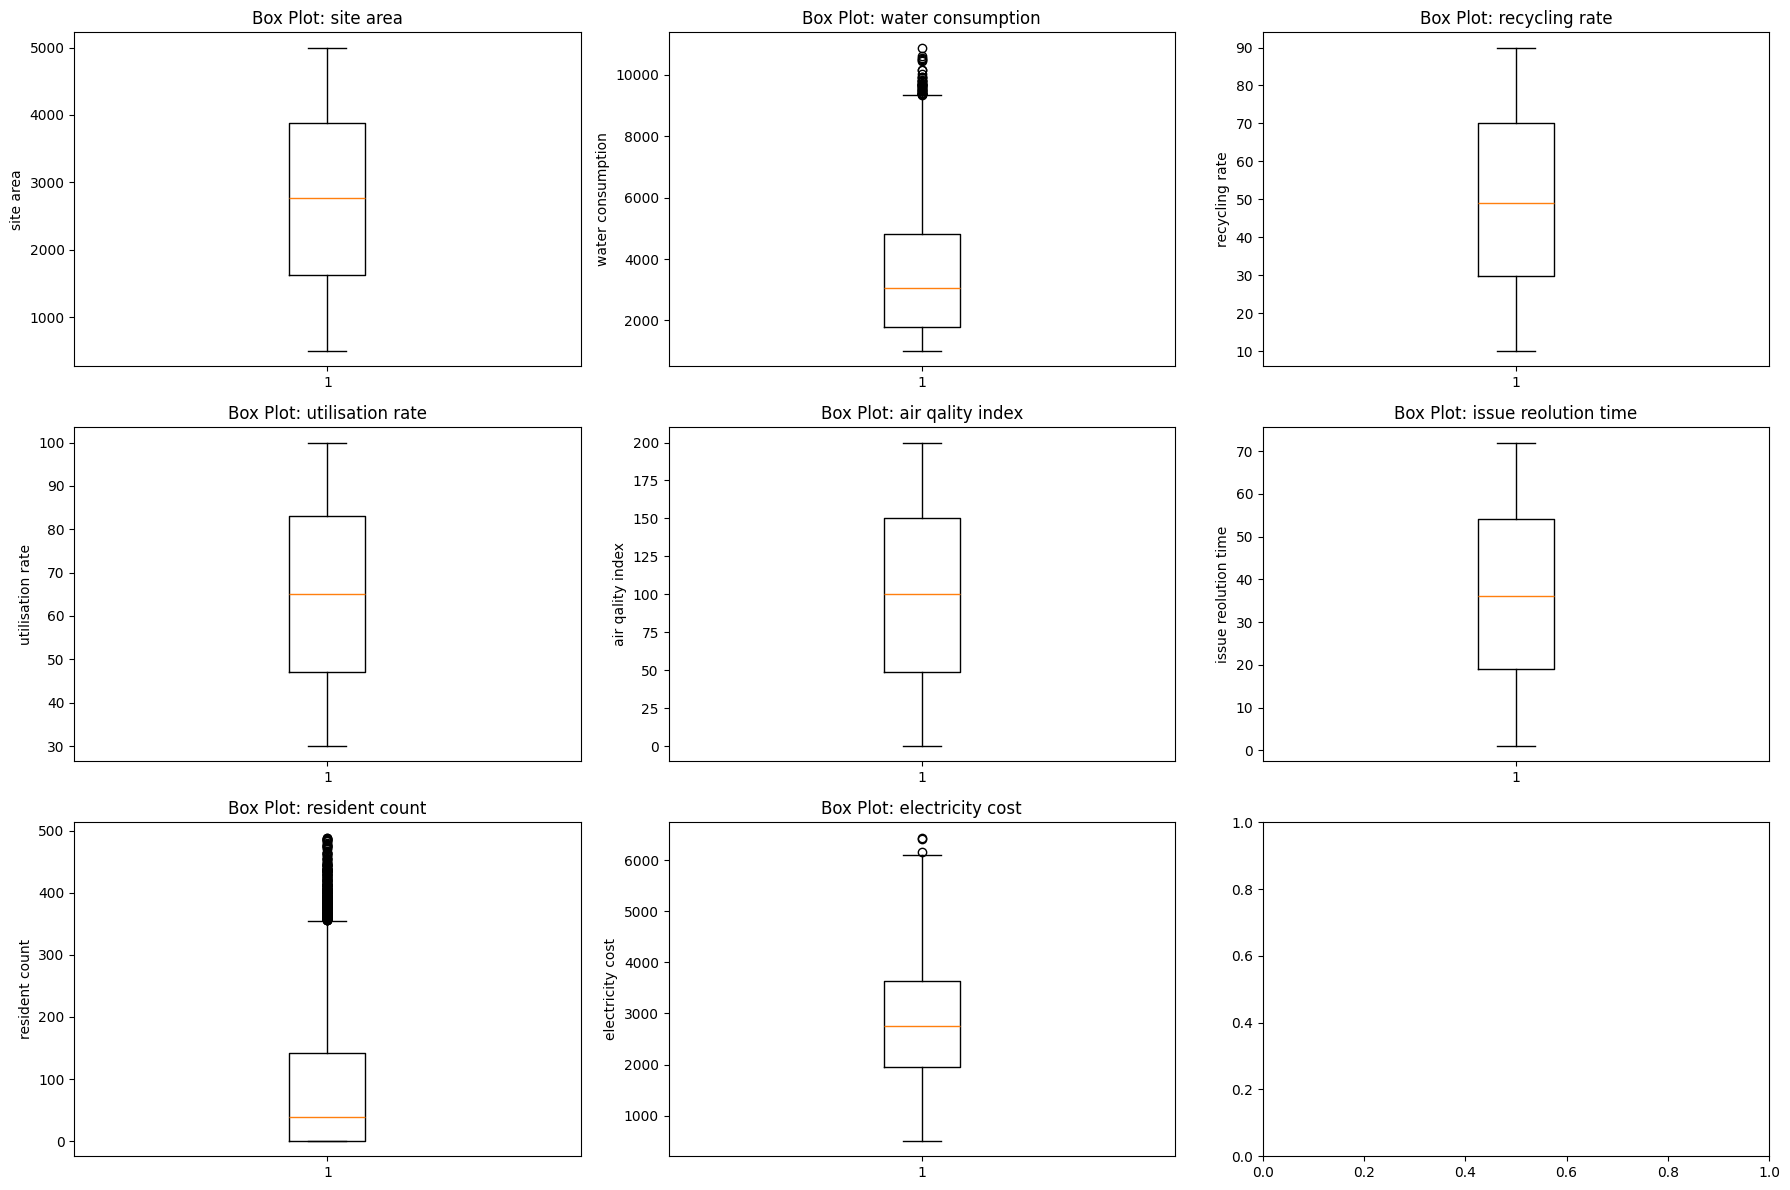

In [ ]:
# 7. Outlier detection using box plots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols + ['electricity cost']):
    axes[idx].boxplot(df_electricity[col])
    axes[idx].set_ylabel(col)
    axes[idx].set_title(f'Box Plot: {col}')
plt.tight_layout()
plt.show()

Data Preprocessing

In [ ]:
# Detect outliers
def detect_outliers_iqr(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers detected (Lower: {lower_bound:.2f}, Upper: {upper_bound:.2f})")
    return outlier_summary

print("Outlier Detection:")
outlier_info = detect_outliers_iqr(df_electricity, numerical_cols + ['electricity cost'])


Outlier Detection:
site area: 0 outliers detected (Lower: -1751.00, Upper: 7249.00)
water consumption: 43 outliers detected (Lower: -2769.00, Upper: 9359.00)
recycling rate: 0 outliers detected (Lower: -30.62, Upper: 130.38)
utilisation rate: 0 outliers detected (Lower: -7.00, Upper: 137.00)
air qality index: 0 outliers detected (Lower: -102.50, Upper: 301.50)
issue reolution time: 0 outliers detected (Lower: -33.50, Upper: 106.50)
resident count: 289 outliers detected (Lower: -213.00, Upper: 355.00)
electricity cost: 3 outliers detected (Lower: -563.00, Upper: 6149.00)


In [ ]:
# Preprocessing
df_electricity_processed = df_electricity.copy()

# Encode categorical variable
le = LabelEncoder()
df_electricity_processed['structure type'] = le.fit_transform(df_electricity_processed['structure type'])

# Print encoding mapping
structure_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nStructure Type Encoding:")
print(structure_mapping)



Structure Type Encoding:
{'Commercial': np.int64(0), 'Industrial': np.int64(1), 'Mixed-use': np.int64(2), 'Residential': np.int64(3)}


In [ ]:
# Check for any remaining issues
print("\nProcessed Data Info:")
print(df_electricity_processed.info())

print("\nmissing values after processing:", df_electricity_processed.isnull().sum().sum())

# Separate features and target
X = df_electricity_processed.drop('electricity cost', axis=1)
y = df_electricity_processed['electricity cost']

print(f"\nFeatures shape: {X.shape}")

print(f"Target shape: {y.shape}")

print(f"\nFeature columns: {list(X.columns)}")


Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   site area             10000 non-null  int64  
 1   structure type        10000 non-null  int64  
 2   water consumption     10000 non-null  float64
 3   recycling rate        10000 non-null  int64  
 4   utilisation rate      10000 non-null  int64  
 5   air qality index      10000 non-null  int64  
 6   issue reolution time  10000 non-null  int64  
 7   resident count        10000 non-null  int64  
 8   electricity cost      10000 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 703.3 KB
None

missing values after processing: 0

Features shape: (10000, 8)
Target shape: (10000,)

Feature columns: ['site area', 'structure type', 'water consumption', 'recycling rate', 'utilisation rate', 'air qality index', 'issue reolution time', 'resident cou

In [ ]:
# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Training set size: 8000
Test set size: 2000


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also keeping non-scaled versions for tree-based models
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Scaled training data shape: {X_train_scaled.shape}")

Scaled training data shape: (8000, 8)


Step 2: Build Neural Network for Regression

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Build Neural Network for Regression
model_nn_reg = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),  # Use Input layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # Single output for regression
])
# Compile model
model_nn_reg.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)
# Print model architecture
print("Neural Network Architecture:")
model_nn_reg.summary()

Neural Network Architecture:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
history = model_nn_reg.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8153611.5000 - mae: 2583.2212 - mse: 8153611.5000 - val_loss: 340923.4062 - val_mae: 452.6639 - val_mse: 340923.4062
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 482506.2500 - mae: 539.6585 - mse: 482506.2500 - val_loss: 223959.5469 - val_mae: 366.7698 - val_mse: 223959.5469
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 374327.7500 - mae: 480.6720 - mse: 374327.7500 - val_loss: 202366.5469 - val_mae: 345.0084 - val_mse: 202366.5469
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 359588.8438 - mae: 467.9836 - mse: 359588.8438 - val_loss: 174794.6875 - val_mae: 313.2476 - val_mse: 174794.6875
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 329559.0000 - mae: 446.7022 - mse: 329559.0000 - val_loss: 170094.0469 - val_mae: 309.2833 - val_mse: 170094.0469
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 322287.0938 - mae: 437.3670 - mse: 322287.0938 - val_loss: 16

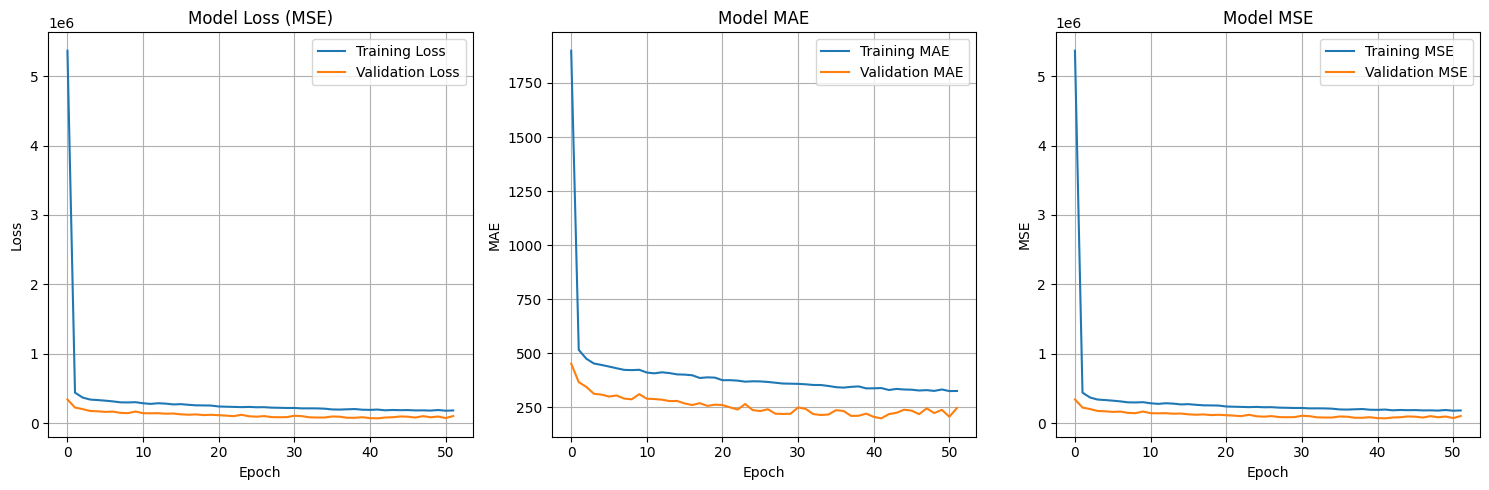

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Predictions
y_pred_nn_train = model_nn_reg.predict(X_train_scaled).flatten()
y_pred_nn_test = model_nn_reg.predict(X_test_scaled).flatten()

# Evaluate on training set
print("\n Neural Network - Training Set Performance ")
print(f"MAE:  {mean_absolute_error(y_train, y_pred_nn_train):.4f}")
print(f"MSE:  {mean_squared_error(y_train, y_pred_nn_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_nn_train)):.4f}")
print(f"R² Score: {r2_score(y_train, y_pred_nn_train):.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

 Neural Network - Training Set Performance 
MAE:  203.5371
MSE:  69165.3232
RMSE: 262.9930
R² Score: 0.9433


In [ ]:
# Evaluate on test set
print("\nNeural Network - Test Set Performance ")
mae_nn = mean_absolute_error(y_test, y_pred_nn_test)
mse_nn = mean_squared_error(y_test, y_pred_nn_test)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn_test)

print(f"MAE:  {mae_nn:.4f}")
print(f"MSE:  {mse_nn:.4f}")
print(f"RMSE: {rmse_nn:.4f}")
print(f"R² Score: {r2_nn:.4f}")


Neural Network - Test Set Performance 
MAE:  202.5096
MSE:  69036.8013
RMSE: 262.7486
R² Score: 0.9447


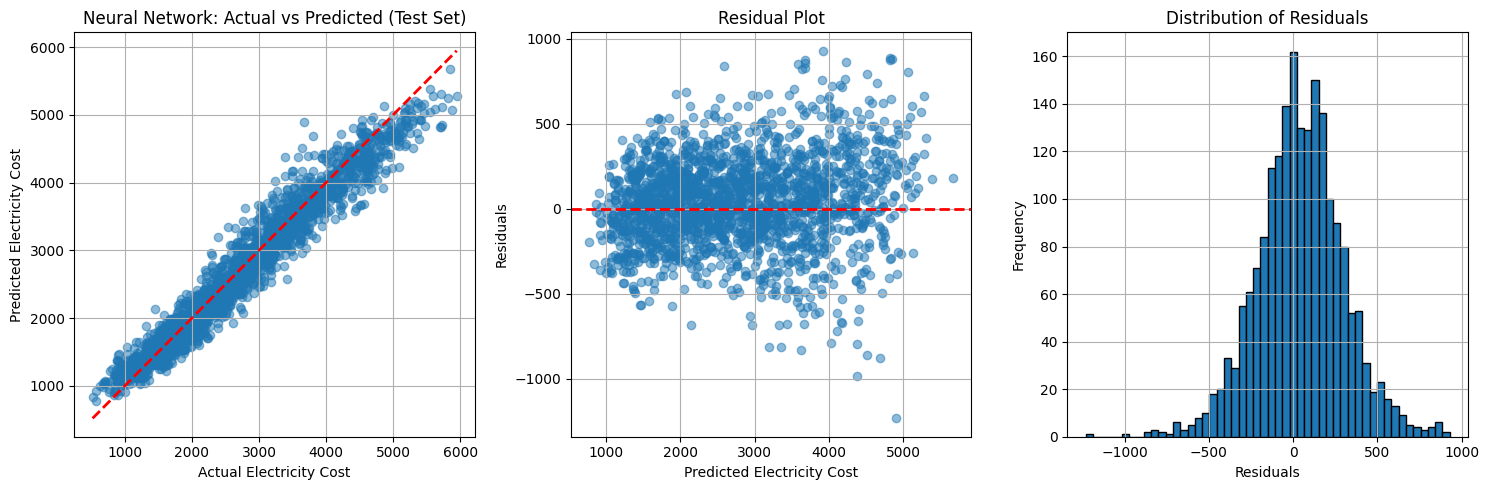

In [ ]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_nn_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Electricity Cost')
plt.ylabel('Predicted Electricity Cost')
plt.title('Neural Network: Actual vs Predicted (Test Set)')
plt.grid(True)

plt.subplot(1, 3, 2)
residuals = y_test - y_pred_nn_test
plt.scatter(y_pred_nn_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Electricity Cost')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

Step 3: Build Two Classical ML Models

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Model 1: Linear Regression
model_lr_reg = LinearRegression()
model_lr_reg.fit(X_train_scaled, y_train)

y_pred_lr_train = model_lr_reg.predict(X_train_scaled)
y_pred_lr_test = model_lr_reg.predict(X_test_scaled)

print("\n Linear Regression - Training Set ")
print(f"MAE:  {mean_absolute_error(y_train, y_pred_lr_train):.4f}")
print(f"MSE:  {mean_squared_error(y_train, y_pred_lr_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_lr_train)):.4f}")
print(f"R² Score: {r2_score(y_train, y_pred_lr_train):.4f}")

print("\n Linear Regression - Test Set ")
mae_lr = mean_absolute_error(y_test, y_pred_lr_test)
mse_lr = mean_squared_error(y_test, y_pred_lr_test)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr_test)

print(f"MAE:  {mae_lr:.4f}")
print(f"MSE:  {mse_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")

# Feature coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr_reg.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nFeature Coefficients:")
print(coefficients)


 Linear Regression - Training Set 
MAE:  368.6369
MSE:  230466.4675
RMSE: 480.0692
R² Score: 0.8110

 Linear Regression - Test Set 
MAE:  374.6765
MSE:  234848.7650
RMSE: 484.6120
R² Score: 0.8117

Feature Coefficients:
                Feature  Coefficient
0             site area   839.057741
4      utilisation rate   212.098180
2     water consumption   119.652299
7        resident count    93.042458
1        structure type   -50.744176
6  issue reolution time    43.811204
5      air qality index    27.450541
3        recycling rate   -11.853953


In [ ]:
# Model 2: Random Forest Regressor

model_rf_reg = RandomForestRegressor(random_state=42, n_estimators=100)
model_rf_reg.fit(X_train, y_train)  # Tree models don't need scaling

y_pred_rf_train = model_rf_reg.predict(X_train)
y_pred_rf_test = model_rf_reg.predict(X_test)

print("\n Random Forest - Training Set ")
print(f"MAE:  {mean_absolute_error(y_train, y_pred_rf_train):.4f}")
print(f"MSE:  {mean_squared_error(y_train, y_pred_rf_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_rf_train)):.4f}")
print(f"R² Score: {r2_score(y_train, y_pred_rf_train):.4f}")

print("\n Random Forest - Test Set ")
mae_rf = mean_absolute_error(y_test, y_pred_rf_test)
mse_rf = mean_squared_error(y_test, y_pred_rf_test)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf_test)

print(f"MAE:  {mae_rf:.4f}")
print(f"MSE:  {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)



 Random Forest - Training Set 
MAE:  67.0900
MSE:  7172.0460
RMSE: 84.6879
R² Score: 0.9941

 Random Forest - Test Set 
MAE:  181.3344
MSE:  52446.2140
RMSE: 229.0114
R² Score: 0.9580

Feature Importance:
                Feature  Importance
0             site area    0.771451
1        structure type    0.085800
7        resident count    0.071498
4      utilisation rate    0.042309
2     water consumption    0.010255
6  issue reolution time    0.006510
5      air qality index    0.006187
3        recycling rate    0.005990


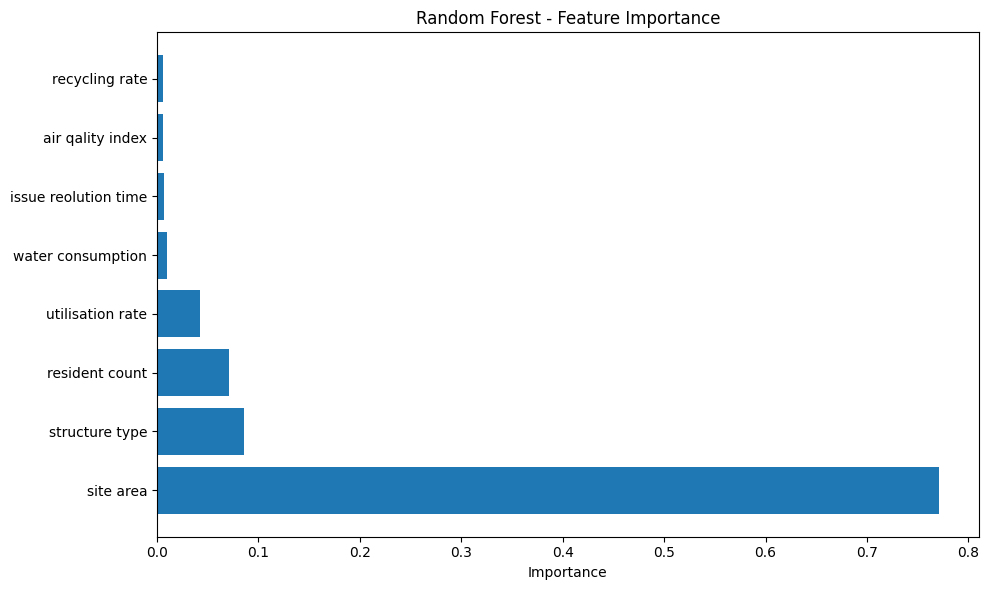

In [ ]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
# Initial Model Comparison
initial_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_rf],
    'MSE': [mse_lr, mse_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'R² Score': [r2_lr, r2_rf]
})
print(initial_comparison)


               Model         MAE            MSE        RMSE  R² Score
0  Linear Regression  374.676542  234848.765022  484.611974  0.811743
1      Random Forest  181.334420   52446.213960  229.011384  0.957959


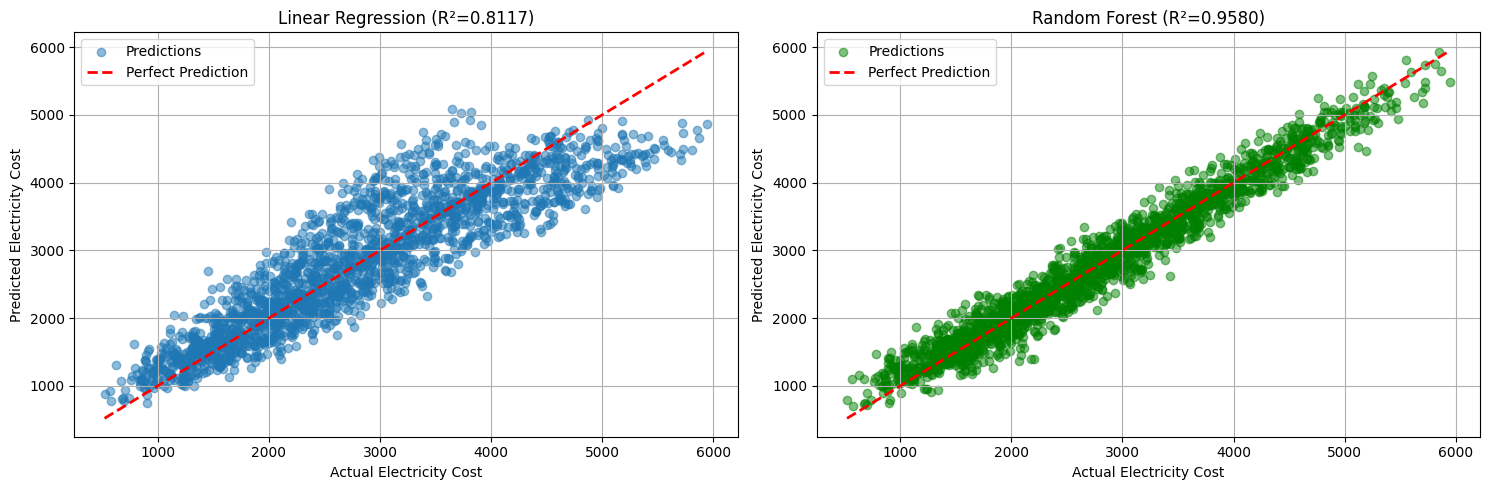

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Linear Regression
axes[0].scatter(y_test, y_pred_lr_test, alpha=0.5, label='Predictions')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Electricity Cost')
axes[0].set_ylabel('Predicted Electricity Cost')
axes[0].set_title(f'Linear Regression (R²={r2_lr:.4f})')
axes[0].legend()
axes[0].grid(True)

# Random Forest
axes[1].scatter(y_test, y_pred_rf_test, alpha=0.5, label='Predictions', color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Electricity Cost')
axes[1].set_ylabel('Predicted Electricity Cost')
axes[1].set_title(f'Random Forest (R²={r2_rf:.4f})')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

Step 4: Hyperparameter Optimization

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

grid_ridge = GridSearchCV(
    Ridge(random_state=42),
    param_grid_ridge,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_ridge.fit(X_train_scaled, y_train)

# Best Ridge model
best_ridge = grid_ridge.best_estimator_

# Cross-validated predictions for RMSE
y_train_pred_cv_ridge = cross_val_predict(best_ridge, X_train_scaled, y_train, cv=5)
cv_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_cv_ridge))

print("\nBest parameters for Ridge Regression:", grid_ridge.best_params_)
print(f"Best CV R² Score: {grid_ridge.best_score_:.4f}")
print(f"Best CV RMSE: {cv_rmse_ridge:.4f}")



Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best parameters for Ridge Regression: {'alpha': 10, 'solver': 'auto'}
Best CV R² Score: 0.8103
Best CV RMSE: 480.7707


In [ ]:
# Top 5 parameter combinations
results_ridge = pd.DataFrame(grid_ridge.cv_results_)
top_results_ridge = results_ridge.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 Ridge parameter combinations:")
print(top_results_ridge)



Top 5 Ridge parameter combinations:
                                 params  mean_test_score  std_test_score
16      {'alpha': 10, 'solver': 'auto'}         0.810281        0.007063
18  {'alpha': 10, 'solver': 'cholesky'}         0.810281        0.007063
17       {'alpha': 10, 'solver': 'svd'}         0.810281        0.007063
19      {'alpha': 10, 'solver': 'lsqr'}         0.810281        0.007063
12       {'alpha': 1, 'solver': 'auto'}         0.810281        0.007101


In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    n_iter=50,  # Try 50 random combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf = random_search_rf.best_estimator_

# Cross-validated predictions for RMSE
y_train_pred_cv_rf = cross_val_predict(best_rf, X_train, y_train, cv=5)
cv_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_cv_rf))

print("\nBest parameters for Random Forest:", random_search_rf.best_params_)
print(f"Best CV R² Score: {random_search_rf.best_score_:.4f}")
print(f"Best CV RMSE: {cv_rmse_rf:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
Best CV R² Score: 0.9568
Best CV RMSE: 229.4271


In [ ]:
# Top 5 parameter combinations
results_rf = pd.DataFrame(random_search_rf.cv_results_)
top_results_rf = results_rf.nsmallest(5, 'rank_test_score')[['params', 'mean_test_score', 'std_test_score']]
print("\nTop 5 Random Forest parameter combinations:")
print(top_results_rf)


Top 5 Random Forest parameter combinations:
                                               params  mean_test_score  \
12  {'n_estimators': 300, 'min_samples_split': 5, ...         0.956806   
8   {'n_estimators': 300, 'min_samples_split': 2, ...         0.956778   
31  {'n_estimators': 300, 'min_samples_split': 2, ...         0.956775   
6   {'n_estimators': 200, 'min_samples_split': 5, ...         0.956772   
46  {'n_estimators': 300, 'min_samples_split': 10,...         0.956562   

    std_test_score  
12        0.001708  
8         0.001730  
31        0.001648  
6         0.001704  
46        0.001703  


In [ ]:
hyperparameter_summary = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'Best CV R² Score': [grid_ridge.best_score_, random_search_rf.best_score_],
    'Best CV RMSE': [cv_rmse_ridge, cv_rmse_rf],
    'Best Parameters': [str(grid_ridge.best_params_), str(random_search_rf.best_params_)]
})
print(hyperparameter_summary)

              Model  Best CV R² Score  Best CV RMSE  \
0  Ridge Regression          0.810281    480.770661   
1     Random Forest          0.956806    229.427084   

                                     Best Parameters  
0                    {'alpha': 10, 'solver': 'auto'}  
1  {'n_estimators': 300, 'min_samples_split': 5, ...  


Step 5: Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import Ridge

# Use Ridge Regression as estimator
ridge_estimator = Ridge(alpha=grid_ridge.best_params_['alpha'], random_state=42)

# RFE to select top 6 features
rfe = RFE(estimator=ridge_estimator, n_features_to_select=6)
rfe.fit(X_train_scaled, y_train)

# Selected features
selected_features_final = X.columns[rfe.support_]
print(f"\nSelected Features (RFE): {list(selected_features_final)}")


Selected Features (RFE): ['site area', 'structure type', 'water consumption', 'utilisation rate', 'issue reolution time', 'resident count']


In [ ]:
# Transform training and test sets
X_train_final = rfe.transform(X_train_scaled)
X_test_final = rfe.transform(X_test_scaled)


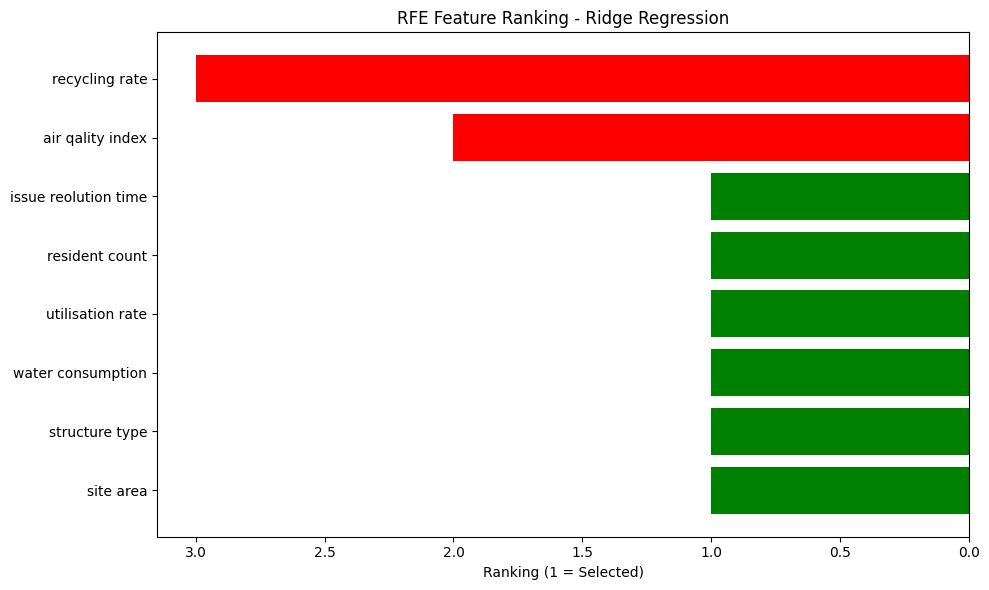

In [ ]:
# Visualize feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Ranking')

plt.figure(figsize=(10, 6))
colors = ['green' if x else 'red' for x in feature_ranking['Selected']]
plt.barh(feature_ranking['Feature'], feature_ranking['Ranking'], color=colors)
plt.xlabel('Ranking (1 = Selected)')
plt.title('RFE Feature Ranking - Ridge Regression')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

Task 6: Final Models and Comparative Analysis

In [ ]:
# Final Ridge Regression Model
final_ridge = Ridge(**grid_ridge.best_params_, random_state=42)
final_ridge.fit(X_train_final, y_train)

y_pred_ridge_train = final_ridge.predict(X_train_final)
y_pred_ridge_test = final_ridge.predict(X_test_final)

# Metrics
mae_ridge_train = mean_absolute_error(y_train, y_pred_ridge_train)
rmse_ridge_train = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
r2_ridge_train = r2_score(y_train, y_pred_ridge_train)

mae_ridge_test = mean_absolute_error(y_test, y_pred_ridge_test)
rmse_ridge_test = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
r2_ridge_test = r2_score(y_test, y_pred_ridge_test)

cv_ridge_scores = cross_val_score(final_ridge, X_train_final, y_train, cv=5, scoring='r2')
cv_ridge_mean = cv_ridge_scores.mean()

print("\n Ridge Regression Performance ")
print(f"Training: MAE={mae_ridge_train:.4f}, RMSE={rmse_ridge_train:.4f}, R²={r2_ridge_train:.4f}")
print(f"Testing:  MAE={mae_ridge_test:.4f}, RMSE={rmse_ridge_test:.4f}, R²={r2_ridge_test:.4f}")
print(f"5-Fold CV R²: {cv_ridge_mean:.4f} (+/- {cv_ridge_scores.std():.4f})")


 Ridge Regression Performance 
Training: MAE=369.8132, RMSE=481.0096, R²=0.8103
Testing:  MAE=376.1092, RMSE=485.3212, R²=0.8112
5-Fold CV R²: 0.8096 (+/- 0.0071)


In [ ]:
# Final Random Forest Model (using same RFE features)
# Use the same selected feature indices for original X_train
selected_indices = [i for i, x in enumerate(rfe.support_) if x]
X_train_rf_final = X_train.iloc[:, selected_indices]
X_test_rf_final = X_test.iloc[:, selected_indices]

final_rf = RandomForestRegressor(**random_search_rf.best_params_, random_state=42)
final_rf.fit(X_train_rf_final, y_train)

y_pred_rf_train = final_rf.predict(X_train_rf_final)
y_pred_rf_test = final_rf.predict(X_test_rf_final)

# Metrics
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
r2_rf_train = r2_score(y_train, y_pred_rf_train)

mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
r2_rf_test = r2_score(y_test, y_pred_rf_test)

cv_rf_scores = cross_val_score(final_rf, X_train_rf_final, y_train, cv=5, scoring='r2')
cv_rf_mean = cv_rf_scores.mean()

print("\n Random Forest Performance ")
print(f"Training: MAE={mae_rf_train:.4f}, RMSE={rmse_rf_train:.4f}, R²={r2_rf_train:.4f}")
print(f"Testing:  MAE={mae_rf_test:.4f}, RMSE={rmse_rf_test:.4f}, R²={r2_rf_test:.4f}")
print(f"5-Fold CV R²: {cv_rf_mean:.4f} (+/- {cv_rf_scores.std():.4f})")


 Random Forest Performance 
Training: MAE=88.3874, RMSE=113.5906, R²=0.9894
Testing:  MAE=180.1067, RMSE=226.5391, R²=0.9589
5-Fold CV R²: 0.9568 (+/- 0.0017)


In [ ]:
# Step 4: Comparison Table
final_comparison_table = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'Features Used': [len(selected_features_final), len(selected_features_final)],
    'CV R² Score': [cv_ridge_mean, cv_rf_mean],
    'Test MAE': [mae_ridge_test, mae_rf_test],
    'Test RMSE': [rmse_ridge_test, rmse_rf_test],
    'Test R²': [r2_ridge_test, r2_rf_test]
})

print("\nFINAL MODEL COMPARISON TABLE")
print(final_comparison_table.to_string(index=False))


FINAL MODEL COMPARISON TABLE
           Model  Features Used  CV R² Score   Test MAE  Test RMSE  Test R²
Ridge Regression              6     0.809625 376.109209 485.321172 0.811192
   Random Forest              6     0.956850 180.106746 226.539095 0.958862


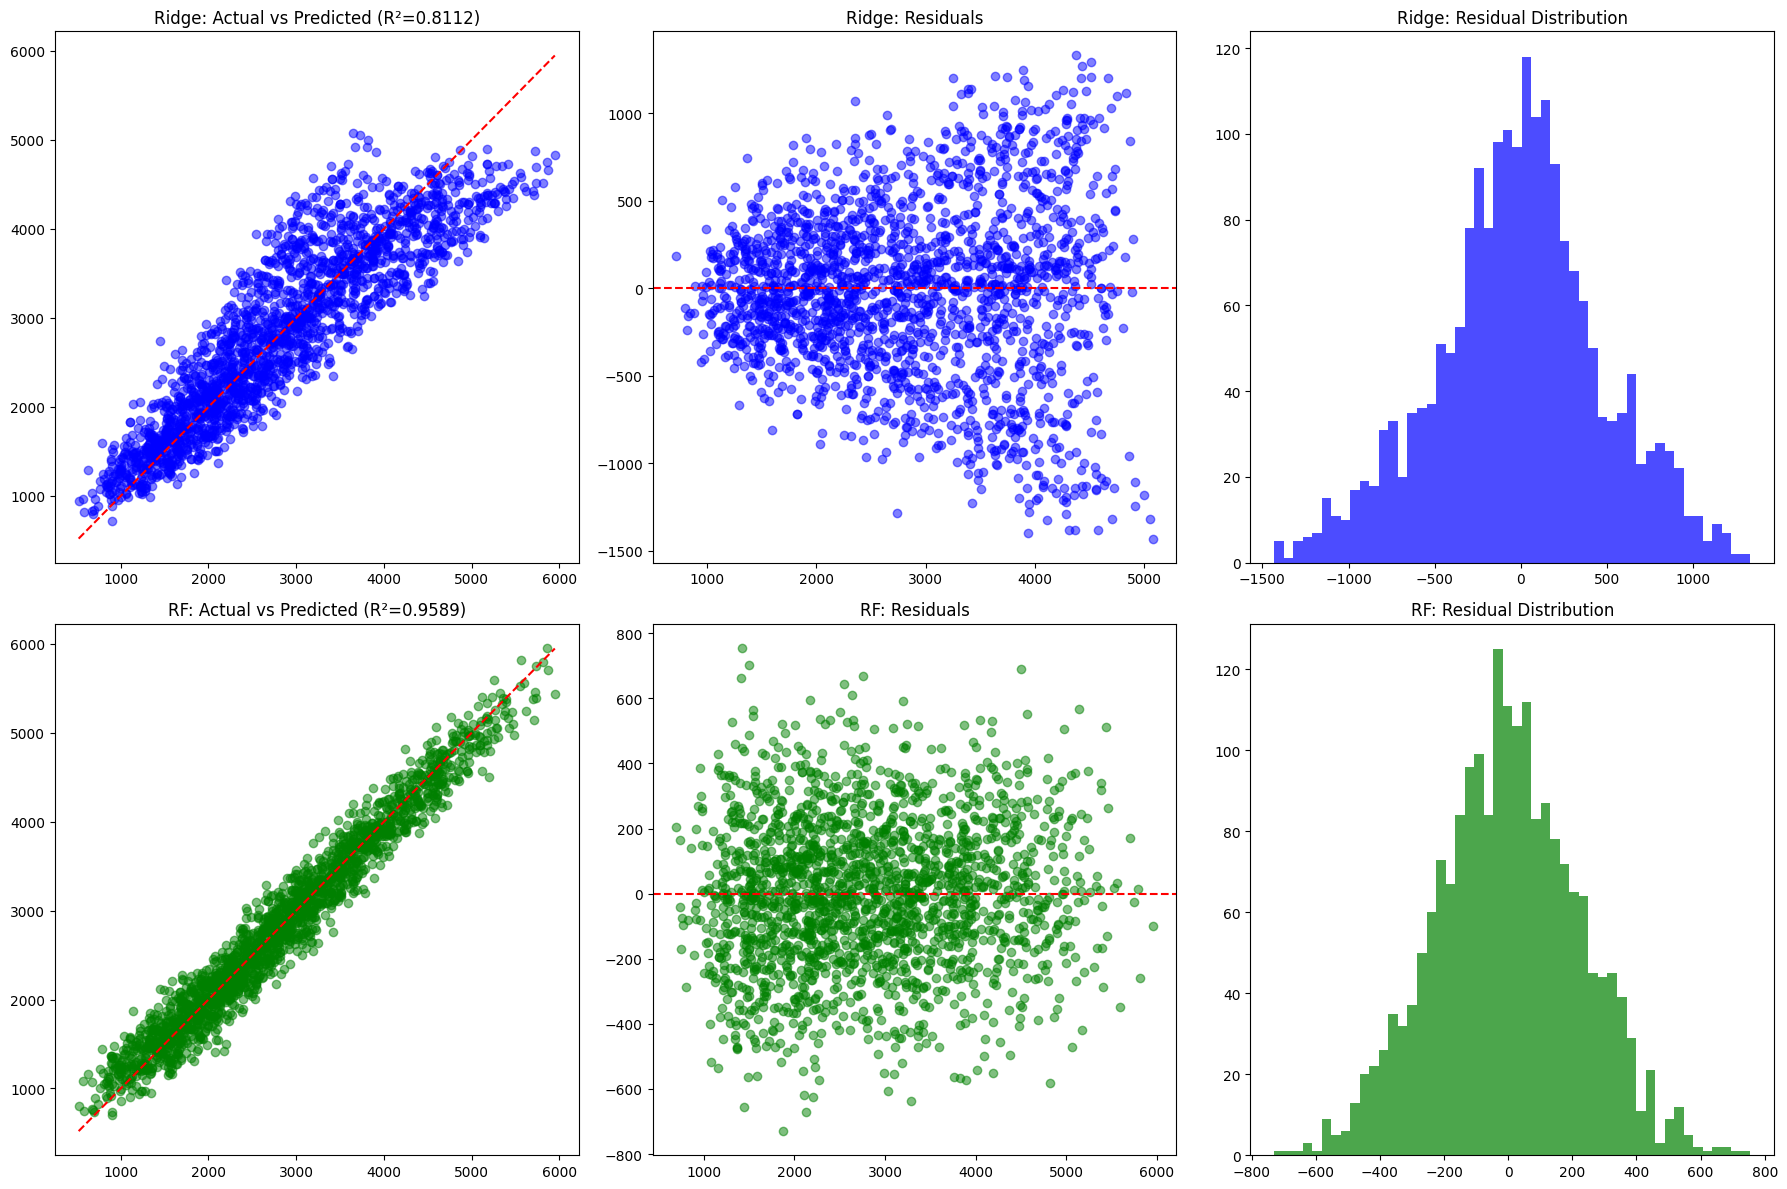

In [ ]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Ridge: Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_ridge_test, alpha=0.5, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_title(f'Ridge: Actual vs Predicted (R²={r2_ridge_test:.4f})')

# Ridge: Residuals
residuals_ridge = y_test - y_pred_ridge_test
axes[0, 1].scatter(y_pred_ridge_test, residuals_ridge, alpha=0.5, color='blue')
axes[0, 1].axhline(0, color='r', linestyle='--')
axes[0, 1].set_title('Ridge: Residuals')

# Ridge: Residual Distribution
axes[0, 2].hist(residuals_ridge, bins=50, color='blue', alpha=0.7)
axes[0, 2].set_title('Ridge: Residual Distribution')

# RF: Actual vs Predicted
axes[1, 0].scatter(y_test, y_pred_rf_test, alpha=0.5, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1, 0].set_title(f'RF: Actual vs Predicted (R²={r2_rf_test:.4f})')

# RF: Residuals
residuals_rf = y_test - y_pred_rf_test
axes[1, 1].scatter(y_pred_rf_test, residuals_rf, alpha=0.5, color='green')
axes[1, 1].axhline(0, color='r', linestyle='--')
axes[1, 1].set_title('RF: Residuals')

# RF: Residual Distribution
axes[1, 2].hist(residuals_rf, bins=50, color='green', alpha=0.7)
axes[1, 2].set_title('RF: Residual Distribution')

plt.tight_layout()
plt.show()

In [ ]:
#Best Model Selection
if r2_rf_test > r2_ridge_test:
    best_model = "Random Forest"
    best_score = r2_rf_test
else:
    best_model = "Ridge Regression"
    best_score = r2_ridge_test

print(f"\n✓ BEST MODEL: {best_model} with R²={best_score:.4f}")


✓ BEST MODEL: Random Forest with R²=0.9589
